# Training Regression Models on chemical reactions

> Here we show how simple it is to train reaction BERTs on any regression task.

## Available tools

BERT and related transformer models have revolutionised Natural Language Processing. The implementation of such models is conveniently made available through the [Huggingface Transformers](https://github.com/huggingface/transformers) library. We based already based our previous work on reaction fingerprints / classification and atom-mapping on this library. To train the yield regression models in this work, we used the [SimpleTransformers.ai](https://simpletransformers.ai), which contains all you need to add fine-tuning heads on top of transformers, run trainings and evaluations.

## SmilesTokenizer

One key difference compared to human languages, when compared to chemistry are the tokens and tokenizers. In this work, we use the tokenizer introduced our previous [rxnfp](https://rxn4chemistry.github.io/rxnfp/) work with the same regex as in the [Molecular Transformer](https://github.com/pschwllr/MolecularTransformer). 

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


['C', 'C', '(', 'C', ')', '[C@@H]', '(', 'C', ')', 'C', 'C', 'Br', '.', '[Na]', 'C', '#', 'N', '>>', 'C', 'C', '(', '[C@@H]', '(', 'C', ')', 'C', 'C', 'C', '#', 'N', ')', 'C']


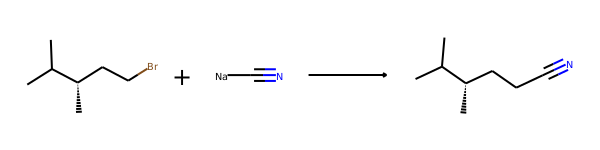

In [ ]:
from rxnfp.tokenization import get_default_tokenizer, SmilesTokenizer
from rdkit.Chem import rdChemReactions

smiles_tokenizer = get_default_tokenizer()

reaction_smiles = 'CC(C)[C@@H](C)CCBr.[Na]C#N>>CC([C@@H](C)CCC#N)C'
rxn = rdChemReactions.ReactionFromSmarts(reaction_smiles,useSmiles=True)

print(smiles_tokenizer.tokenize(reaction_smiles))
rxn

As the tokenizer is normally hard-coded in the SimpleTransformers library we need to change it, we therefore create a `SmilesClassificationModel` class, as seen in the `core` module. 

```python
MODEL_CLASSES = {
            "bert": (BertConfig, BertForSequenceClassification, SmilesTokenizer),
        }
```

Once this is done, the SimpleTransformers library can be used as usual. 



## Pretrained reaction BERT models

There are currently two reaction BERT models in the `rxnfp` library - `pretrained` (trained with on a reaction MLM task) and `ft` (additionally trained on a reaction classification task). For this example, we will use the `pretrained` model as starting point for the training of our Yield-BERT. On the Buchwald-Hartwig reactions both base models performed similarly.

In [ ]:
import pkg_resources
import torch
from rxnfp.models import SmilesClassificationModel
model_path =  pkg_resources.resource_filename(
                "rxnfp",
                f"models/transformers/bert_pretrained" # change pretrained to ft to start from the other base model
)
yield_bert = SmilesClassificationModel('bert', model_path, use_cuda=torch.cuda.is_available())

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


## Prepare the data

Load the reaction SMILES and yield values into a DataFrame with columns `['text', 'labels']`.

The same procedure could be applied to any reaction (or molecule) regression task.

In [ ]:
# data
import pandas as pd
from rxn_yields.data import generate_buchwald_hartwig_rxns
df = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx', sheet_name='FullCV_01')
df['rxn'] = generate_buchwald_hartwig_rxns(df)

train_df = df.iloc[:2767][['rxn', 'Output']] 
test_df = df.iloc[2767:][['rxn', 'Output']] #

train_df.columns = ['text', 'labels']
test_df.columns = ['text', 'labels']
mean = train_df.labels.mean()
std = train_df.labels.std()
train_df['labels'] = (train_df['labels'] - mean) / std
test_df['labels'] = (test_df['labels'] - mean) / std
train_df.head()

,text,labels
0,CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.COc1...,1.387974
1,Brc1ccccn1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C...,-0.796876
2,CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2...,-0.827835
3,CCOC(=O)c1cnoc1.CN1CCCN2CCCN=C12.COc1ccc(OC)c(...,-0.464841
4,CN1CCCN2CCCN=C12.COc1ccc(Cl)cc1.COc1ccc(OC)c(P...,-1.186082


## Hyperparameter tuning

Most of the hyperparameter are already fixed by the base model. Here we decided only to tune the `dropout probability` and the `learning rate`. SimpleTransformers has [wandb](https://www.wandb.com) nicely integrated. An example how to setup a hyperparameter sweep can be found in the training scripts. The wandb parameters are read using [dotenv](https://pypi.org/project/python-dotenv/).

## Training

As you can also be seen from the training scripts, once the data is in the right shape a training run can be started within a few lines of code. 

For this example we will go with the following parameters,
> {dropout=0.7987, learning_rate=0.00009659},

and launch a training. We have to reinitiate the BERT model with the correct parameters.

In [ ]:
# data
model_args = {
     'num_train_epochs': 15, 'overwrite_output_dir': True,
    'learning_rate': 0.00009659, 'gradient_accumulation_steps': 1,
    'regression': True, "num_labels":1, "fp16": False,
    "evaluate_during_training": False, 'manual_seed': 42,
    "max_seq_length": 300, "train_batch_size": 16,"warmup_ratio": 0.00,
    "config" : { 'hidden_dropout_prob': 0.7987 } 
}

model_path =  pkg_resources.resource_filename(
                "rxnfp",
                f"models/transformers/bert_pretrained" # change pretrained to ft to start from the other base model
)

yield_bert = SmilesClassificationModel("bert", model_path, num_labels=1, 
                                       args=model_args, use_cuda=torch.cuda.is_available())

yield_bert.train_model(train_df, output_dir=f"outputs_buchwald_hartwig_test_project", eval_df=test_df)

## Predictions

To load a trained model and make yield predictions. We change the `model_path` to the folder that contains the trained model and use the `predict` method. 

In [ ]:
# data
model_path = '../trained_models/buchwald_hartwig/FullCV_01_split_2768/checkpoint-2595-epoch-15'
trained_yield_bert = SmilesClassificationModel('bert', model_path,
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())

yield_predicted = trained_yield_bert.predict(test_df.head(10).text.values)[0]
yield_predicted = yield_predicted * std + mean

yield_true = test_df.head(10).labels.values
yield_true = yield_true * std + mean

for rxn, pred, true in zip(test_df.head(10).text.values, yield_predicted, yield_true):
    print(rxn)
    print(f"predicted {pred:.1f} | {true:.1f} true yield")
    print()

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



Brc1ccccn1.CN(C)C(=NC(C)(C)C)N(C)C.COc1ccc(OC)c(P(C(C)(C)C)C(C)(C)C)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2ccccc2-c2ccccc2[NH2]1)C(F)(F)F.c1ccc(CN(Cc2ccccc2)c2ccno2)cc1>>Cc1ccc(Nc2ccccn2)cc1
predicted 37.0 | 38.1 true yield

Brc1cccnc1.CC(C)c1cc(C(C)C)c(-c2ccccc2P(C(C)(C)C)C(C)(C)C)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.COC(=O)c1ccno1.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2ccccc2-c2ccccc2[NH2]1)C(F)(F)F>>Cc1ccc(Nc2cccnc2)cc1
predicted 15.4 | 14.8 true yield

CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.COc1ccc(OC)c(P([C@]23C[C@H]4C[C@H](C[C@H](C4)C2)C3)[C@]23C[C@H]4C[C@H](C[C@H](C4)C2)C3)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C.Cc1ccc(N)cc1.FC(F)(F)c1ccc(Br)cc1.Fc1cccc(F)c1-c1ccno1.O=S(=O)(O[Pd]1c2ccccc2-c2ccccc2[NH2]1)C(F)(F)F>>Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1
predicted 9.1 | 12.2 true yield

CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1.CCOC(=O)c1cc(OC)no1.CN1CCCN2CCCN=C12.Cc1ccc(N)cc1.FC(F)(F)c1ccc(Cl)cc1.O=S(=O)(O[Pd]1c2ccccc2-c2ccccc2[NH2]1)C(F)(F)F>>Cc1ccc(